# Finding communities in a network

Network communities can be loosely defined as groups of nodes that are densely connected to each other but sparsely connected to other nodes. For example, in the below plot the red nodes could belong to one community and the yellow to another

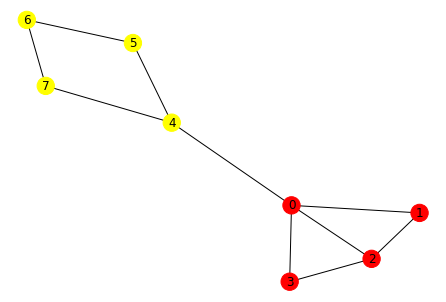

In [7]:
import networkx as nx

g = nx.Graph()
g.add_edge(0,1)
g.add_edge(1,2)
g.add_edge(2,3)
g.add_edge(3,0)
g.add_edge(0,2)
g.add_edge(0,4)

g.add_edge(4,5)
g.add_edge(5,6)
g.add_edge(6,7)
g.add_edge(7,4)

nx.draw(g, node_color = ["red"]*4 + ["yellow"]*4, with_labels = True)

A problem with the above definition is that while intuitive, mathematically rigorous it is not, which makes finding communities a tricky thing.

One very popular concept is that of network modularity. Given a network, and an assigment of nodes to communities in that network, modularity spits out a number between -1/2 and 1 telling us how good our community assingment was based on the notion of intra-community density, that is, how connected are nodes in our communities. The above assingment would get a good score.

More concretely:

$Q = \frac{1}{2m}\sum_{uv}^{}[A_{uv} - E_{uv}]\delta(c_v,c_u)$

Where m is the number of nodes, $A_uv$ is the adjacency matrix value of nodes u and v (1 if they are connected, 0 otherwise), $E_uv$ is the expected adjacency value and $\delta(c_v,c_u)$ is afunction which is 1 if $c_u$ and $c_v$ are the same and 0 otherwise, with $c_u$ and $c_v$ being the communties assigned to nodes u and v.

What modularity is doing is summing over for all node pairs in the same community the difference between the adjacency value of that pair and the probability of them being connected: if two nodes in the same community have a high probability of being together but they arent, thats not a good sign, but if two unlikely nodes are connected in a community, then thats a good assignment.

An important point is how to calculate $E_{uv}$. A popular choice is $\frac{k_uk_v}{2m}$ where $k_u$ is the nodes degree. Popular nodes therefore have a higher expected probability to connect other nodes, which makes sense. However you could use a single probability value for all nodes, $\frac{number of edges}{\frac{N(N+1)}{2}}$

So Q gives us how to evaluate a community assingment but.... how do we maximize it for a given graph? Unfortunately, that is an NP-complete problem. While we wait for the math community to determine whether P = NP, several algorith,s (louvain for example) have been developed to find good communities. We however are going to be using, you guessed it, genetic algorithms for the job. We are going to maximize modularity, so that seems like a fine fitness function, but it can take negative values down to -0.5, so lets add one to the result, and also lets square it, since Ive found it produces good results faster.

In [9]:
def modularity(node_assingments):
    
    Q = 0
    m = 2*g.order()
    
    for u in g:
        
        for v in g:
            
            if u != v and node_assingments[u] == node_assingments[v]:
                
                Q += g.has_edge(u,v) - g.degree(u)*g.degree(v)/(m)
                
    return (1 + Q/m)**2

What values can our variable take though? Well if we have n nodes, the maximum number of communities possible that makes sense is n, with each node belonging to a separate community. In our example above, the red nodes could belong to community 1 and the yellow to community 2.

What if we changed it around though?

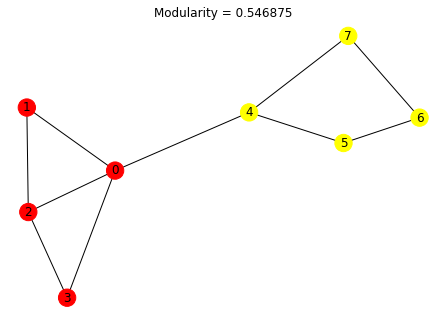

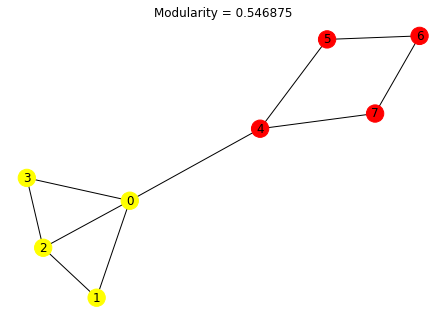

In [12]:
import matplotlib.pyplot as plt

communities_1 = ["red"]*4 + ["yellow"]*4
_ = nx.draw(g, node_color = communities_1, with_labels = True)
mod = modularity(communities_1)
mod = mod**0.5 - 1
plt.title(f"Modularity = {mod}")
_ = plt.show()



communities_2 = ["yellow"]*4 + ["red"]*4
_ = nx.draw(g, node_color = communities_2, with_labels = True)
mod = modularity(communities_2)
mod = mod**0.5 - 1
plt.title(f"Modularity = {mod}")
_ = plt.show()

The labeling is different, but the communities are the same. This is because the labels themeselves (node zero belonging to yellow or red for example) dont matter, its how the labels of each node compare to each other (node zero belonging in the same community as 1, 2, and 3). As such, there are many (a bit less than half) community assingments that are essentially the same, and with a simple trick we can reduce the search space:

* Have the first node only be able to take on one community value. The second node can then take on 2 community values: it can belong to the first one, or to its own community. The third node can take on three community values, and so on.
* We go from $n^2$ possible node assingments to 1 + 2 + 3 + ... + n = $\frac{n^2 + n}{2}$ which is actually a lot less possible assingments especially for bigger networks

We will try this with the karate club graph. We will also put a maximum of 5 possible communities, instead of up to n.

In [13]:
from pyGeneticAlgorithm.discrete_solver import discreteGeneticSolver as dGS

g = nx.karate_club_graph()

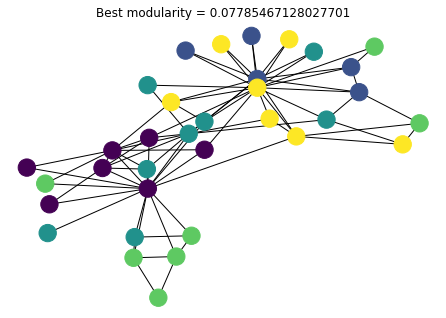

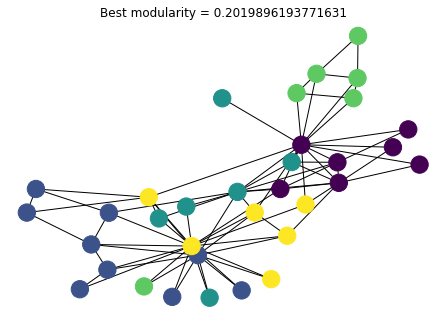

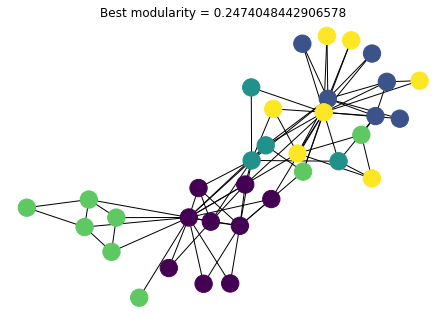

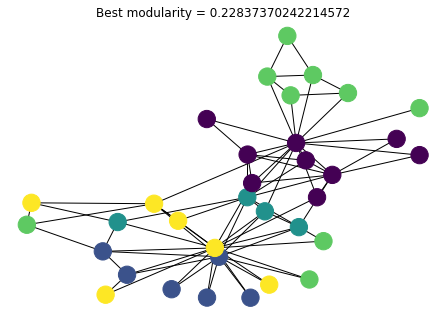

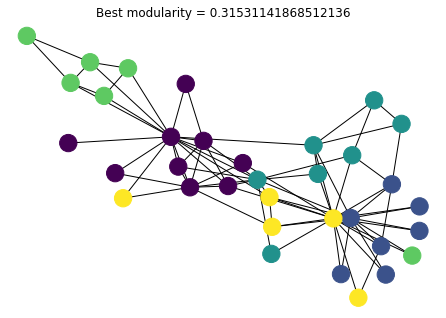

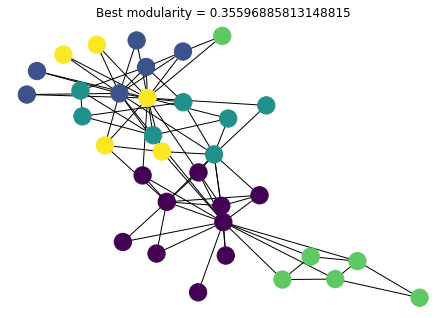

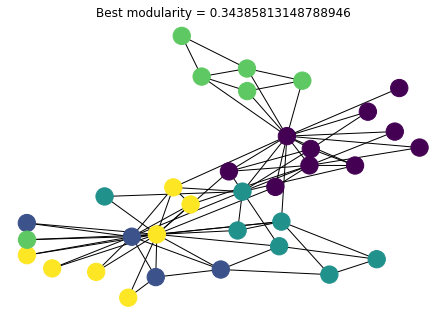

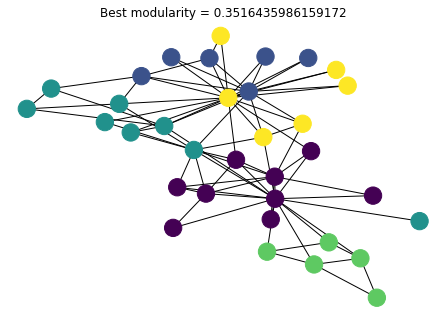

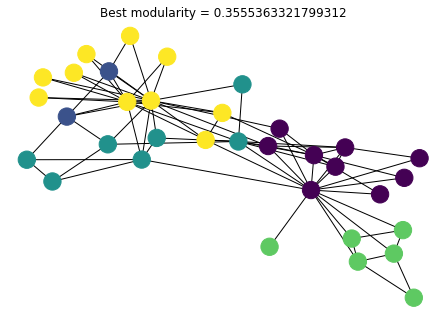

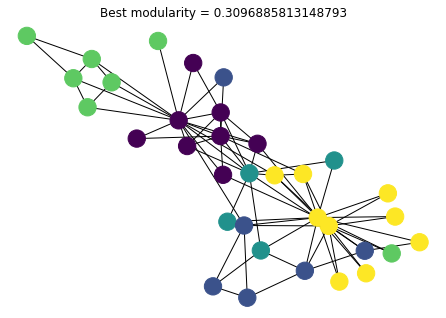

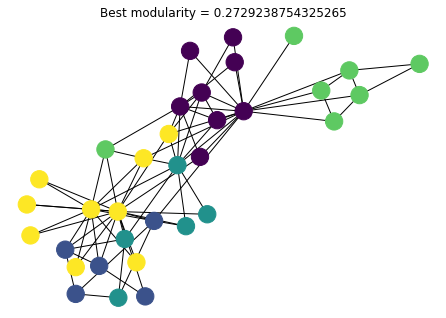

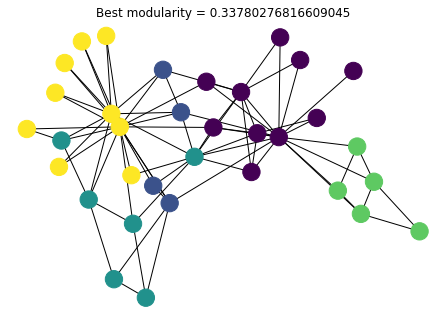

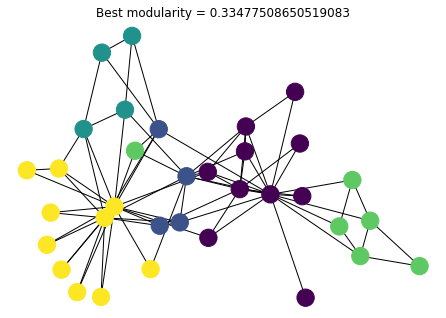

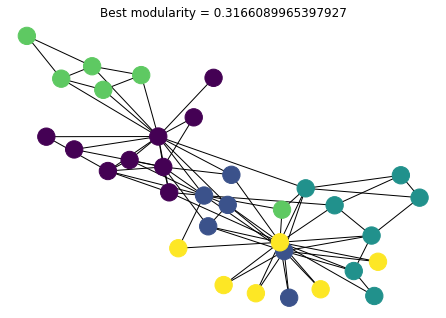

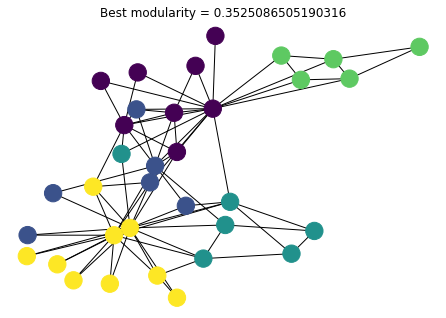

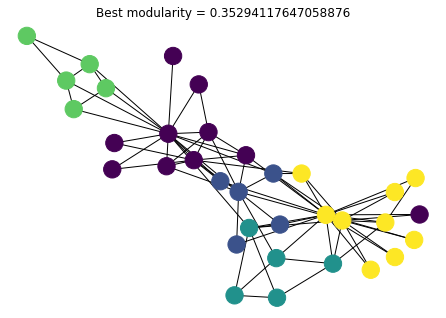

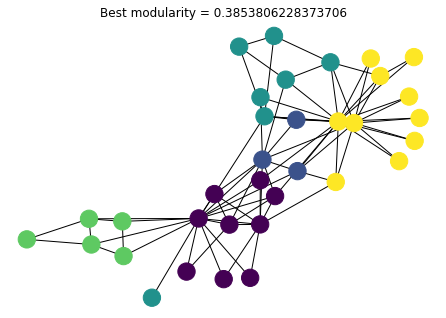

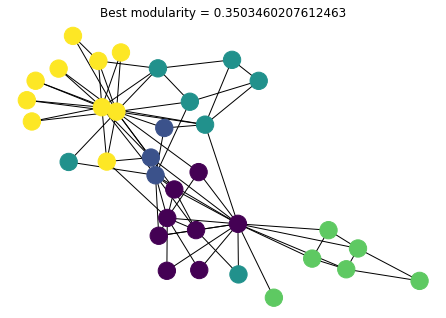

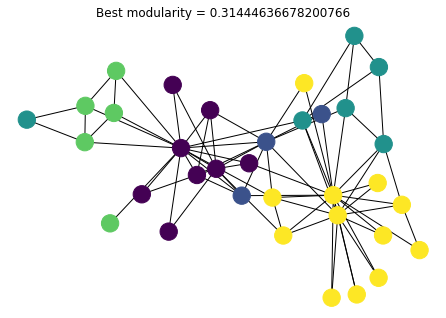

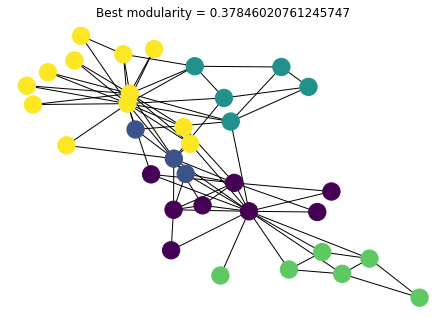

In [15]:
universe = [ list(range(min(i, 5))) for i in range(1,len(g)+1)]
dsg = dGS(0.01,"midpoint",universe, len(universe),modularity, 10000,universe_type="specific")

for i in range(20):
    
    best_res = dsg.solve(100,verbose=False)
    _ = nx.draw(g, node_color = best_res)
    mod = modularity(best_res)
    mod = mod**0.5 - 1
    plt.title(f"Best modularity = {mod}")
    _ = plt.show()